In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.signal
import scipy.cluster.vq as vq
import scipy.io.wavfile as wav
import python_speech_features as speech
from sklearn import mixture
from sklearn.mixture import GaussianMixture as gmm
import scipy.spatial.distance as dist
import math

In [271]:
def BIC(k, Sigs, Koefs, Lengths, penalty):
    P1 = Lengths[Koefs[k][0]]* np.log(np.abs(np.cov(Sigs[Koefs[k][0]])+0.0001))
    P2 = Lengths[Koefs[k][1]] * np.log(np.abs(np.cov(Sigs[Koefs[k][1]])+0.0001))
    P3 = (Lengths[Koefs[k][0]]+Lengths[Koefs[k][1]])*np.log(np.abs(np.linalg.det(np.cov(Sigs[Koefs[k][0]], Sigs[Koefs[k][1]]))+0.0001))
    bic= 0.5*P1 + 0.5*P2-0.5*P3  + penalty*(2.5*(Lengths[Koefs[k][0]]+Lengths[Koefs[k][1]]))
    return bic

In [272]:
def fit_samples(samples, num):
	gmix = mixture.GaussianMixture(n_components=num, covariance_type='full')
	gmix.fit(samples)
	return (gmix.means_)

#glavna funkcija:
def calculate(Means, Mfccs, Sigs, Lengths, Freqs, M, num, penalty):
    N = min(num, 25)
    
    global ind
    
    Koefs = []
    for i in range(0, N):
        Koefs.append([0,0])
    
    MaxVals = np.zeros((N))
    
    #racunanje N najblizih koeficijenata
    for i in range(0,num-1):
        for j in range(2,num):
            if(j>i and i not in Merged and j not in Merged):
                
                for l in range(0,N):
                    if(M[i][j]>=MaxVals[l]):
                        for k in range(N, l+1):
                            MaxVals[k]=MaxVals[k-1]
                            Koefs[k] = Koefs[k-1]
                        MaxVals[l] = M[i][j]
                        Koefs[l] = [i,j]
                        break
        
    #racunanje najveceg BIC
    Bics = []
        
    for i in range(0, N):
        if(Koefs[i] == [0,0]):
            N = N-1
            continue
        Bics.append(BIC(i, Sigs, Koefs, Lengths, penalty))
    
    if(len(Bics)<=1):
        ind =-1
        return
        
    max_bic = Bics[0]
    max_i=0
    for i in range(1,N):
        if(Bics[i]>max_bic):
            max_bic = Bics[i]
            max_i = i
        
    Means_new = []
    Mfccs_new = []
    Sigs_new = []
    Lengths_new = []
    Freqs_new = []
    M_new = np.zeros((num+1, num+1))
    
    if(max_bic<0):
        return (Means_new, Mfccs_new, Sigs, Lengths_new, Freqs_new, M_new, -1)
    
    [i,j] = Koefs[max_i]
    spoji_klastere(i, j)
    sig_new = 0.5*Sigs[i]+0.5*Sigs[j]
    means_new = 0.5*Means[i]+0.5*Means[j]
    
    for k in range (0,num):
        Sigs_new.append(Sigs[k])
        Mfccs_new.append(Mfccs[k])
        Means_new.append(Means[k])
        Lengths_new.append(Mfccs[k].shape[0])
        Freqs_new.append(Freqs[k])
        Merged.append(i)
        Merged.append(j)
    
    for k in range(0, num):
        for l in range(0, num):
            M_new[k][l] = M[k][l]

    freq = means_new
    freq_sum = np.sum(freq)
    freq = (freq_sum - freq)/freq_sum
    
    for k in range(0, num):
        M_new[k][num] = np.abs(dist.cosine(Freqs[k], freq))
               
    Lengths_new.append(speech.mfcc(sig_new).shape[0])
    Means_new.append(means_new)        
    Mfccs_new.append(speech.mfcc(sig_new))
    Sigs_new.append(sig_new)
    Freqs_new.append(freq)
    return (Means_new, Mfccs_new, Sigs_new, Lengths_new, Freqs_new, M_new, 1)

In [273]:
def spoji_klastere(i, j):   
    global Clusters_Pred
    global num1
    global num
    
    clust_1 = min(Clusters_Pred[i], Clusters_Pred[j])
    clust_2 = max(Clusters_Pred[i], Clusters_Pred[j])
    
    for k in range(0, len(Clusters_Pred)):
            if(Clusters_Pred[k]==clust_2):
                Clusters_Pred[k]=clust_1
    
    if(clust_1!=clust_2):
        Clusters_Pred.append(clust_1)
    else:
        num = num-1


In [339]:
(rate,sig1) = wav.read("richard3.wav")
(rate,sig2) = wav.read("amy3.wav")
(rate,sig3) = wav.read("derek3.wav")
(rate,sig4) = wav.read("paolo3.wav")
(rate,sig5) = wav.read("nilofer3.wav")

People =[sig1, sig2, sig3]#, sig4, sig5]
Sigs=[]

Clusters_True = []
Clusters_Pred = []
Clusters_Temp = []

k=1
c = 0
for sig in People:
    while((3000*k)<sig.shape[0] and k<30):
        if(sig.ndim==1):
            k = k+1
            continue
        else:
            sign1 = sig[(k-1)*3000: k*3000]
            Sigs.append(sign1[:,0])
            Clusters_True.append(c)
        k = k+1
    k=1
    c = c+1
    
for i in range(0, len(Clusters_True)):
    Clusters_Pred.append(i)
    Clusters_Temp.append(-1)
    
num = len(Sigs)
br_klast = 0
        
num1 = len(Sigs)
    
mfcc_feat = np.copy(speech.mfcc(Sigs[0]))
Lengths = []#mfcc lengths
Mfccs = []
Freqs = []
Merged = []
    
for i in range(0, num):
    mfcc = speech.mfcc(Sigs[i])
    Mfccs.append(mfcc)
    if(i>0):
         mfcc_feat = np.vstack((mfcc_feat, speech.mfcc(Sigs[i])))
    Lengths.append(mfcc.shape[0])   
    
Means = fit_samples(mfcc_feat, num)

for i in range(0, num):
    freq = Means[i]
    freq_sum = np.sum(freq)
    freq = (freq_sum - freq)/freq_sum
    Freqs.append(freq)
    
M = np.zeros((num,num))
for i in range(0,num):
    for j in range(0,num):
        if(i==j):
            M[i][j]=0
        else:
            M[i][j] = np.abs(dist.cosine(Freqs[i], Freqs[j]))
        

In [340]:
ind = 1
br_izb = 0
penalty = 2.0
SigTest = Sigs

while(ind>0 and num<1.5*num1):
    (Means, Mfccs, Sigs, Lengths, Freqs, M, ind) = calculate(Means, Mfccs, Sigs, Lengths, Freqs, M, num, penalty)
    num = num+1
    
Clusters_Pred = Clusters_Pred[0:num1]

Crvena linija - dvoje govornika;
Zelena - troje;
Crna - cetvoro;
Plava - pet

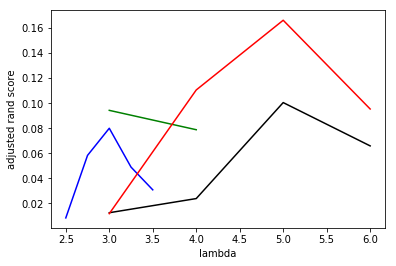

In [346]:
plt.plot([2.5, 2.75, 3.0, 3.25, 3.5], [0.0084893512164360627, 0.058373901752287974, 0.080020519988401762, 0.04903893368251009, 0.030893062200095738],'b-')
plt.plot([3.0, 4.0, 5.0, 6.0], [0.012635494836764788, 0.023927580403038686, 0.10050651119374433, 0.065951682457237218], 'k-')
plt.plot([3.0, 4.0], [0.094306851077516865, 0.078854427534835958], 'g-')
plt.plot([3.0, 4.0, 5.0, 6.0], [0.01187366421277606, 0.11057599691774227, 0.16619905335075283, 0.09539311644642437], 'r-')
plt.ylabel('adjusted rand score')
plt.xlabel('lambda')
plt.show()